# Deep Deterministic Policy Gradients (DDPG) Continuous Control - Reacher

This notebook presents a solution to the [Udacity Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) Project 2 - Continuous Control of the [Unity3D](https://unity3d.com/machine-learning/) [Reacher environment](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#reacher) (agent code [here](https://github.com/Unity-Technologies/ml-agents/blob/master/UnitySDK/Assets/ML-Agents/Examples/Reacher/Scripts/ReacherAgent.cs)) where the goal is to move a double-jointed "arm" using four torques (two for each joint, "shoulder" and "elbow") to reach and maintain a target location.

A reward of +0.01 is provided for each step that the agent's hand is in the goal location (see [ReacherGoal.cs](https://github.com/Unity-Technologies/ml-agents/blob/master/UnitySDK/Assets/ML-Agents/Examples/Reacher/Scripts/ReacherGoal.cs), line 41).

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [4]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 2.0.10 which is incompatible.


Environments corresponding to both a single agent and 20 agent version of the environment are already saved in the Workspace and can be accessed at the file paths provided below.  

This solution applies to the **20 agent** version.

In [5]:
from unityagents import UnityEnvironment
import numpy as np

# select this option to load version 1 (with a single agent) of the environment
#env = UnityEnvironment(file_name='/data/Reacher_One_Linux_NoVis/Reacher_One_Linux_NoVis.x86_64')

# select this option to load version 2 (with 20 agents) of the environment
env = UnityEnvironment(file_name='/data/Reacher_Linux_NoVis/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. 

Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [6]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
print("Using {}".format(brain_name))

Using ReacherBrain


### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]

state_vector_names = ["pendulumA.transform.localPosition",
"pendulumA.transform.rotation     ",
"rbA.angularVelocity              ",
"rbA.velocity                     ",
"pendulumB.transform.localPosition",
"pendulumB.transform.rotation     ",
"rbB.angularVelocity              ",
"rbB.velocity                     ",
"goal.transform.localPosition     ",
"hand.transform.localPosition     ",
"goalSpeed                        "]

print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The reshaped state vector for the first agent looks like:')
_ = [print(state_vector_names[index], vector3) for index, vector3 in enumerate(states[0].reshape((11, 3)))]

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The reshaped state vector for the first agent looks like:
pendulumA.transform.localPosition [ 0. -4.  0.]
pendulumA.transform.rotation      [ 1. -0. -0.]
rbA.angularVelocity               [ -4.37113883e-08   0.00000000e+00   0.00000000e+00]
rbA.velocity                      [ 0.  0.  0.]
pendulumB.transform.localPosition [  0.   0. -10.]
pendulumB.transform.rotation      [ 0.  1. -0.]
rbB.angularVelocity               [ -0.00000000e+00  -4.37113883e-08   0.00000000e+00]
rbB.velocity                      [ 0.  0.  0.]
goal.transform.localPosition      [ 0.          0.          5.75471878]
hand.transform.localPosition      [-1.          5.55726624  0.        ]
goalSpeed                         [ 1.          0.         -0.16816485]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [8]:
env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 0.12349999723955989


### 4. Train the Agents with Deep Deterministic Policy Gradients (DDPG)

Run the code cells below to train the agents. 

The **Actor** and **Critic** agents are based on the example in the [Udacity Deep Reinforcement Learning github repository](https://github.com/udacity/deep-reinforcement-learning) where DDPG was applied to the [BipedalWalker environment](https://github.com/udacity/deep-reinforcement-learning/tree/master/ddpg-bipedal). 

Modifications were made to the code to allow learning from 20 instances of the virtual arm simultaneously (hence, the **num_agents** parameter). 

In [9]:
import datetime
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
from ddpg_agent import Agents

agents = Agents(state_size=state_size, 
                action_size=action_size, 
                num_agents=num_agents, 
                random_seed=0)

In [11]:
# Actor Model Size
Actor_HL1 = 450        # 1st Hidden layer Size
Actor_HL2 = 450        # 2nd Hidden Layer Size

# Critic Model Size
Critic_HL1 = 250       # 1st Hidden layer Size
Critic_HL2 = 250       # 1st Hidden layer Size

BATCH_SIZE = 128        # minibatch size
BUFFER_SIZE = int(1e5)  # replay buffer size
GAMMA = 0.97            # discount factor
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
TAU = 1e-3              # for soft update of target parameters
WEIGHT_DECAY = 0        # L2 weight decay

In [12]:
def ddpg(n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        state = env_info.vector_observations
        agents.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            action = agents.act(state)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            agents.step(state, action, rewards, next_state, dones)
            state = next_state
            score += rewards
            if np.any(dones):
                print('\tSteps: ', t)
                break 
        scores_deque.append(np.mean(score))
        scores.append(np.mean(score))
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.3f}\t'.format(i_episode, 
                                                                          np.mean(scores_deque), 
                                                                          np.mean(score)), end="")
        average_score = np.mean(scores_deque)
        if i_episode % 25 == 0 or average_score > 30:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth') 
            if average_score > 30:
                break
    return scores

In [10]:
import time

start_time = time.time()                                 # Monitor Training Time
results = ddpg(n_episodes=5000, max_t=1000)
print("\nTotal Training time = {:.1f} min".format((time.time()-start_time)/60))

Episode 25	Average Score: 1.85	Score: 4.315	
Episode 50	Average Score: 6.51	Score: 22.354	
Episode 75	Average Score: 13.29	Score: 31.417	
Episode 100	Average Score: 18.86	Score: 38.346	
Episode 125	Average Score: 27.55	Score: 37.493	
Episode 133	Average Score: 30.01	Score: 36.333	

Total Training time = 81.2 min


### 5. Plotting the learning curve

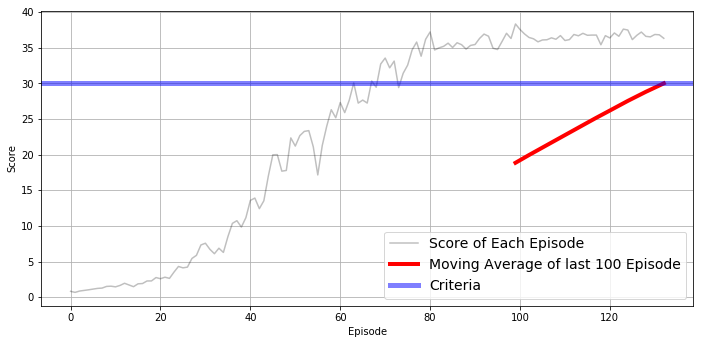

In [11]:
###
import pandas as pd

scores = results
Target_Score = 30.0

fig, ax = plt.subplots(1, 1, figsize=[10, 5])
plt.rcParams.update({'font.size': 14})

scores_rolling = pd.Series(scores).rolling(100).mean()
ax.plot(scores, "-", c="black", alpha=0.25)
ax.plot(scores_rolling, "-", c="red", linewidth=4)
ax.set_xlabel("Episode")
ax.set_ylabel("Score")
ax.grid(which="major")
ax.axhline(Target_Score, c="blue", linewidth=5, alpha=0.5)
ax.legend(["Score of Each Episode", "Moving Average of last 100 Episode", "Criteria"])

fig.tight_layout()
fig.savefig("result_score.jpg")

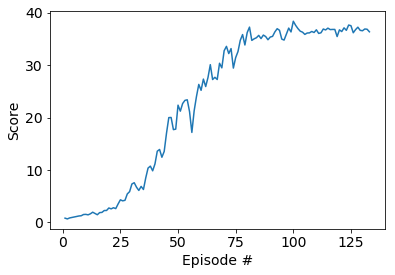

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 6. Testing the Trained Agent
 
 After traing the Agent we are going to load the wieghts for the actor and critic components of the agent, and then test this agent for one episode (max_t = 1000).



In [21]:
agent = Agents(state_size=state_size, action_size=action_size, num_agents=num_agents, random_seed=2)

checkpoint_actor_file  = 'checkpoint_actor_v0.4.pth'
checkpoint_critic_file = 'checkpoint_critic_v0.4.pth'

agent.actor_local.load_state_dict(torch.load(checkpoint_actor_file))
agent.critic_local.load_state_dict(torch.load(checkpoint_critic_file))

env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
state    = env_info.vector_observations               # get the current state (for each agent)
#print(state)
agent.reset()
scores   = np.zeros(num_agents)                        # initialize the score (for each agent)

for t in range(1000):
    action = agent.act(state)
    
    env_info = env.step(action)[brain_name]        
    next_state = env_info.vector_observations    
    rewards = env_info.rewards                     
    dones = env_info.local_done
    
    state = next_state
    scores += rewards
    
    if np.any(dones):                                  # exit loop if episode finished
        break 

print('Total score for the Agent in this episode: {}'.format(np.mean(scores)))

Total score for the Agent in this episode: 37.10149917071685


When finished, you can close the environment.

In [ ]:
env.close()